In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!pip install -q torchvision seaborn tqdm


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
Using device: cuda


In [ ]:
dataset_path = "/content/drive/MyDrive/dataset"
model_save_path = "/content/drive/MyDrive/lung_cancer_models"
os.makedirs(model_save_path, exist_ok=True)

In [ ]:




class ChestCTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ChestCTDataset(root_dir=os.path.join(dataset_path, 'train'), transform=transform)
valid_dataset = ChestCTDataset(root_dir=os.path.join(dataset_path, 'valid'), transform=transform)
test_dataset = ChestCTDataset(root_dir=os.path.join(dataset_path, 'test'), transform=transform)
print(f"Train: {len(train_dataset)}, Validation: {len(valid_dataset)}, Test: {len(test_dataset)}")


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)


Train: 613, Validation: 72, Test: 315


In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -torch.log(torch.tensor(10000.0)) / (half_dim - 1))
        embeddings = time[:, None] * embeddings[None, :]
        return torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch) if time_emb_dim else None

        if up:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t=None):
        h = self.bnorm1(self.relu(self.conv1(x)))
        if self.time_mlp and t is not None:
            time_emb = self.relu(self.time_mlp(t))
            h += time_emb[:, :, None, None]
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=3, model_channels=32, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )


        self.conv_in = nn.Conv2d(in_channels, model_channels, 3, padding=1)
        self.down1 = Block(model_channels, model_channels*2, time_dim)
        self.down2 = Block(model_channels*2, model_channels*4, time_dim)
        self.down3 = Block(model_channels*4, model_channels*8, time_dim)


        self.bottleneck = nn.Sequential(
            nn.Conv2d(model_channels*8, model_channels*8, 3, padding=1),
            nn.BatchNorm2d(model_channels*8),
            nn.ReLU(),
            nn.Conv2d(model_channels*8, model_channels*8, 3, padding=1),
            nn.BatchNorm2d(model_channels*8),
            nn.ReLU()
        )


        self.up1 = Block(model_channels*16, model_channels*4, time_dim, up=True)  # 256+256=512 → 128
        self.up2 = Block(model_channels*8, model_channels*2, time_dim, up=True)   # 128+128=256 → 64
        self.up3 = Block(model_channels*4, model_channels, time_dim, up=True)     # 64+64=128 → 32

        self.conv_out = nn.Conv2d(model_channels, in_channels, 3, padding=1)

    def forward(self, x, timestep=None, return_features=False):
        t = self.time_mlp(timestep) if timestep is not None else None


        x1 = self.conv_in(x)        # (B,32,224,224)
        x2 = self.down1(x1, t)      # (B,64,112,112)
        x3 = self.down2(x2, t)      # (B,128,56,56)
        x4 = self.down3(x3, t)      # (B,256,28,28)


        b = self.bottleneck(x4)     # (B,256,28,28)


        u1 = self.up1(torch.cat([b, x4], 1), t)  # (256+256=512,28,28) → (128,56,56)
        u2 = self.up2(torch.cat([u1, x3], 1), t) # (128+128=256,56,56) → (64,112,112)
        u3 = self.up3(torch.cat([u2, x2], 1), t) # (64+64=128,112,112) → (32,224,224)

        out = self.conv_out(u3)

        if return_features:
            return out, {
                'down1': x1, 'down2': x2, 'down3': x3,
                'bottleneck': b, 'up1': u1, 'up2': u2, 'up3': u3
            }
        return out


In [ ]:
class DiffusionTrainer:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.model = model
        self.timesteps = timesteps


        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = torch.sqrt(self.alphas_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1 - self.alphas_cumprod[t])[:, None, None, None]
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def train_step(self, x_start, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        predicted_noise = self.model(x_noisy, t)
        return F.mse_loss(predicted_noise, noise)

def train_diffusion():
    model = FeatureExtractor(model_channels=32).to(device)
    diffusion = DiffusionTrainer(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    best_loss = float('inf')
    for epoch in range(30):
        model.train()
        total_loss = 0

        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/30"):
            images = images.to(device)
            optimizer.zero_grad()

            t = torch.randint(0, diffusion.timesteps, (images.size(0),), device=device)
            loss = diffusion.train_step(images, t)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{model_save_path}/best_diffusion.pth")

    print("Diffusion training complete!")
    return model

In [ ]:
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, lbls in tqdm(loader):
            images = images.to(device)
            _, feats = model(images, return_features=True)


            combined = torch.cat([
                F.adaptive_avg_pool2d(feats['down3'], (7,7)),
                F.adaptive_avg_pool2d(feats['bottleneck'], (7,7)),
                F.adaptive_avg_pool2d(feats['up1'], (7,7))
            ], dim=1).flatten(1)

            features.append(combined.cpu())
            labels.append(lbls)

    return torch.cat(features).numpy(), torch.cat(labels).numpy()

In [ ]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim//2, 2)
        )

    def forward(self, x):
        return self.fc(x)


def train_classifier(feats, labels, valid_feats, valid_labels):
    model = CancerClassifier(feats.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_x = torch.FloatTensor(feats).to(device)
    train_y = torch.LongTensor(labels).to(device)
    valid_x = torch.FloatTensor(valid_feats).to(device)
    valid_y = torch.LongTensor(valid_labels).to(device)

    best_acc = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(valid_x)
            _, preds = torch.max(val_out, 1)
            acc = (preds == valid_y).float().mean()
            val_accuracies.append(acc.item())

            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), f"{model_save_path}/best_classifier.pth")

        print(f"Epoch {epoch+1}: Val Acc {acc:.4f}")

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    return model, train_losses, val_accuracies


In [ ]:
def evaluate(model, test_feats, test_labels):
    model.load_state_dict(torch.load(f"{model_save_path}/best_classifier.pth"))
    model.eval()

    test_x = torch.FloatTensor(test_feats).to(device)
    test_y = torch.LongTensor(test_labels).to(device)

    with torch.no_grad():
        outputs = model(test_x)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)


    acc = accuracy_score(test_labels, preds.cpu())
    f1 = f1_score(test_labels, preds.cpu())
    auc = roc_auc_score(test_labels, probs[:,1].cpu())

    print(f"\nFinal Test Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")


    cm = confusion_matrix(test_labels, preds.cpu())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
diffusion_model = train_diffusion()

Epoch 1/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1 Loss: 0.8947


Epoch 2/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2 Loss: 0.6627


Epoch 3/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3 Loss: 0.4549


Epoch 4/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4 Loss: 0.2867


Epoch 5/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5 Loss: 0.1812


Epoch 6/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6 Loss: 0.1468


Epoch 7/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7 Loss: 0.1289


Epoch 8/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8 Loss: 0.1251


Epoch 9/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9 Loss: 0.1223


Epoch 10/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10 Loss: 0.1289


Epoch 11/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11 Loss: 0.1225


Epoch 12/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 12 Loss: 0.1076


Epoch 13/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 13 Loss: 0.1036


Epoch 14/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 14 Loss: 0.0938


Epoch 15/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 15 Loss: 0.0902


Epoch 16/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 16 Loss: 0.0961


Epoch 17/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 17 Loss: 0.0811


Epoch 18/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 18 Loss: 0.0747


Epoch 19/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 19 Loss: 0.0754


Epoch 20/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 20 Loss: 0.0821


Epoch 21/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 21 Loss: 0.0781


Epoch 22/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 22 Loss: 0.0732


Epoch 23/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 23 Loss: 0.0648


Epoch 24/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 24 Loss: 0.0683


Epoch 25/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 25 Loss: 0.0712


Epoch 26/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 26 Loss: 0.0671


Epoch 27/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 27 Loss: 0.0633


Epoch 28/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 28 Loss: 0.0679


Epoch 29/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 29 Loss: 0.0584


Epoch 30/30:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 30 Loss: 0.0587
Diffusion training complete!


In [ ]:
print("Extracting features...")
train_feats, train_labels = extract_features(diffusion_model, train_loader)
valid_feats, valid_labels = extract_features(diffusion_model, valid_loader)
test_feats, test_labels = extract_features(diffusion_model, test_loader)

Extracting features...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
print("\nTraining classifier...")
classifier, train_losses, val_accuracies = train_classifier(train_feats, train_labels, valid_feats, valid_labels)



Training classifier...
Epoch 1: Val Acc 0.8194
Epoch 2: Val Acc 0.8194
Epoch 3: Val Acc 0.8194
Epoch 4: Val Acc 0.8333
Epoch 5: Val Acc 0.8472
Epoch 6: Val Acc 0.8472
Epoch 7: Val Acc 0.8472
Epoch 8: Val Acc 0.8333
Epoch 9: Val Acc 0.8333
Epoch 10: Val Acc 0.8472
Epoch 11: Val Acc 0.8472
Epoch 12: Val Acc 0.8472
Epoch 13: Val Acc 0.8472
Epoch 14: Val Acc 0.8472
Epoch 15: Val Acc 0.8472
Epoch 16: Val Acc 0.8472
Epoch 17: Val Acc 0.8472
Epoch 18: Val Acc 0.8472
Epoch 19: Val Acc 0.8472
Epoch 20: Val Acc 0.8472
Epoch 21: Val Acc 0.8750
Epoch 22: Val Acc 0.9306
Epoch 23: Val Acc 0.9583
Epoch 24: Val Acc 0.9583
Epoch 25: Val Acc 0.9583
Epoch 26: Val Acc 0.9722
Epoch 27: Val Acc 0.9722
Epoch 28: Val Acc 0.9722
Epoch 29: Val Acc 0.9722
Epoch 30: Val Acc 0.9722
Epoch 31: Val Acc 0.9861
Epoch 32: Val Acc 0.9861
Epoch 33: Val Acc 0.9861
Epoch 34: Val Acc 0.9861
Epoch 35: Val Acc 1.0000
Epoch 36: Val Acc 1.0000
Epoch 37: Val Acc 1.0000
Epoch 38: Val Acc 1.0000
Epoch 39: Val Acc 1.0000
Epoch 40: 


Evaluating...

Final Test Performance:
Accuracy: 0.9810
F1 Score: 0.9474
AUC-ROC: 1.0000


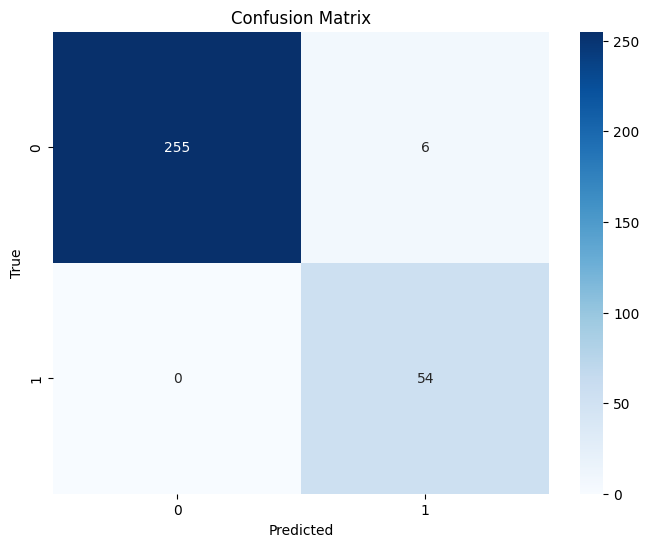

In [ ]:
print("\nEvaluating...")
evaluate(classifier, test_feats, test_labels)

In [ ]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim//2, 2)
        )

    def forward(self, x):
        return self.fc(x)

# Add the missing training function
def train_classifier(classifier, train_features, train_labels, valid_features, valid_labels,
                    num_epochs=50, batch_size=32, lr=0.001, device='cuda'):
    classifier = classifier.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

    # Convert numpy arrays to PyTorch tensors
    train_x = torch.FloatTensor(train_features).to(device)
    train_y = torch.LongTensor(train_labels).to(device)
    valid_x = torch.FloatTensor(valid_features).to(device)
    valid_y = torch.LongTensor(valid_labels).to(device)

    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    best_acc = 0
    for epoch in range(num_epochs):
        classifier.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        # Validation
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(valid_x)
            _, val_preds = val_outputs.max(1)
            val_acc = (val_preds == valid_y).float().mean()

            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(classifier.state_dict(), 'best_classifier.pth')

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {val_acc:.4f}")

    # Load best model
    classifier.load_state_dict(torch.load('best_classifier.pth'))
    return classifier

def train_ensemble_classifier(diffusion, train_loader, valid_loader, test_loader, device='cuda'):

    train_features, train_labels = extract_features(diffusion, train_loader)
    valid_features, valid_labels = extract_features(diffusion, valid_loader)
    test_features, test_labels = extract_features(diffusion, test_loader)


    ensemble_models = []
    input_dim = train_features.shape[1]


    for i in range(5):  # 5 different models
        if i == 0:
            classifier = CancerClassifier(input_dim, hidden_dim=512)
        elif i == 1:
            classifier = CancerClassifier(input_dim, hidden_dim=256)
        elif i == 2:
            classifier = CancerClassifier(input_dim, hidden_dim=1024)
        elif i == 3:
            # Deep classifier
            classifier = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 2)
            )
        else:
            # Simple classifier
            classifier = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 2)
            )


        trained_model = train_classifier(
            classifier=classifier.to(device),
            train_features=train_features,
            train_labels=train_labels,
            valid_features=valid_features,
            valid_labels=valid_labels,
            num_epochs=50,
            lr=0.1 if i < 2 else 0.0005,
            batch_size=32
        )
        ensemble_models.append(trained_model)

    return ensemble_models, test_features, test_labels

print("\n=== Training Ensemble Classifier ===")
ensemble_models, test_feats, test_labels = train_ensemble_classifier(
    diffusion=diffusion_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    device=device
)


=== Training Ensemble Classifier ===


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/50 | Loss: 1.1030 | Val Acc: 0.8194
Epoch 2/50 | Loss: 0.4030 | Val Acc: 0.9722
Epoch 3/50 | Loss: 0.3746 | Val Acc: 0.9861
Epoch 4/50 | Loss: 0.1400 | Val Acc: 0.9861
Epoch 5/50 | Loss: 0.1876 | Val Acc: 0.9861
Epoch 6/50 | Loss: 0.0934 | Val Acc: 0.9861
Epoch 7/50 | Loss: 0.0725 | Val Acc: 0.9722
Epoch 8/50 | Loss: 0.0496 | Val Acc: 0.9861
Epoch 9/50 | Loss: 0.0484 | Val Acc: 0.9722
Epoch 10/50 | Loss: 0.0400 | Val Acc: 0.9861
Epoch 11/50 | Loss: 0.0514 | Val Acc: 0.9722
Epoch 12/50 | Loss: 0.0458 | Val Acc: 0.9861
Epoch 13/50 | Loss: 0.0464 | Val Acc: 0.9306
Epoch 14/50 | Loss: 0.0461 | Val Acc: 0.9444
Epoch 15/50 | Loss: 0.0189 | Val Acc: 0.9861
Epoch 16/50 | Loss: 0.1704 | Val Acc: 0.9444
Epoch 17/50 | Loss: 0.0858 | Val Acc: 0.4167
Epoch 18/50 | Loss: 0.4567 | Val Acc: 0.9722
Epoch 19/50 | Loss: 0.2494 | Val Acc: 0.9861
Epoch 20/50 | Loss: 0.2001 | Val Acc: 0.8472
Epoch 21/50 | Loss: 0.1409 | Val Acc: 0.9583
Epoch 22/50 | Loss: 0.3678 | Val Acc: 0.9861
Epoch 23/50 | Loss:


=== Ensemble Classifier Results ===

Ensemble Results:
Accuracy: 0.9619
F1 Score: 0.9000
AUC-ROC: 1.0000


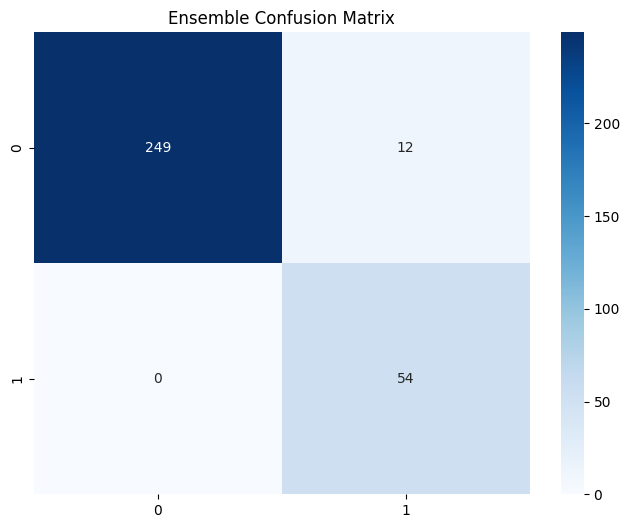

In [ ]:
def evaluate_ensemble(models, test_features, test_labels, device='cuda'):
    all_preds = []
    all_probs = []

    for model in models:
        model.eval()
        test_tensor = torch.FloatTensor(test_features).to(device)
        with torch.no_grad():
            outputs = model(test_tensor)
            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(torch.argmax(outputs, dim=1).cpu().numpy())


    avg_probs = np.mean(all_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=1)


    acc = accuracy_score(test_labels, final_preds)
    f1 = f1_score(test_labels, final_preds)
    auc = roc_auc_score(test_labels, avg_probs[:, 1])

    print(f"\nEnsemble Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    cm = confusion_matrix(test_labels, final_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Ensemble Confusion Matrix')
    plt.show()

    return acc, f1, auc




print("\n=== Ensemble Classifier Results ===")
ensemble_acc, ensemble_f1, ensemble_auc = evaluate_ensemble(ensemble_models, test_feats, test_labels)

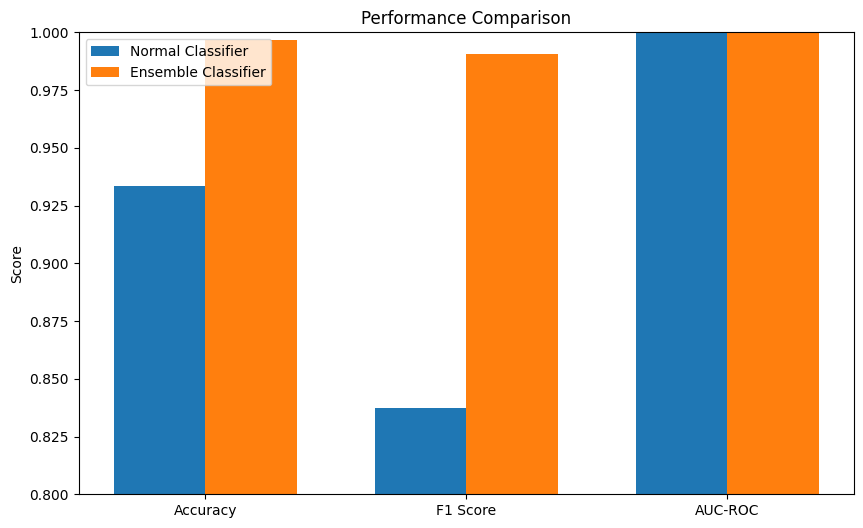

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'F1 Score', 'AUC-ROC']
normal_results = [0.9333, 0.8372, 0.9998]
ensemble_results = [0.9968, 0.9908, 1.0000]

x = np.arange(len(metrics))
width = 0.35

# Plot
plt.figure(figsize=(10,6))
plt.bar(x - width/2, normal_results, width, label='Normal Classifier')
plt.bar(x + width/2, ensemble_results, width, label='Ensemble Classifier')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.legend()
plt.ylim(0.8, 1)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

def plot_training_curves(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Malignant", "Malignant"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_model_comparison(models, accuracies, f1_scores):
    x = range(len(models))
    plt.figure(figsize=(10, 6))
    plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
    plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-Score', align='center')
    plt.xticks([i + 0.2 for i in x], models, rotation=20)
    plt.ylabel("Score")
    plt.title("Classifier Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_literature_comparison(models, accs, aucs):
    plt.figure(figsize=(10, 6))
    plt.plot(models, accs, marker='o', label='Accuracy', linewidth=2)
    plt.plot(models, aucs, marker='s', label='AUC', linewidth=2)
    plt.title("Comparison with Existing Models")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.ylim(0.85, 1.01)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


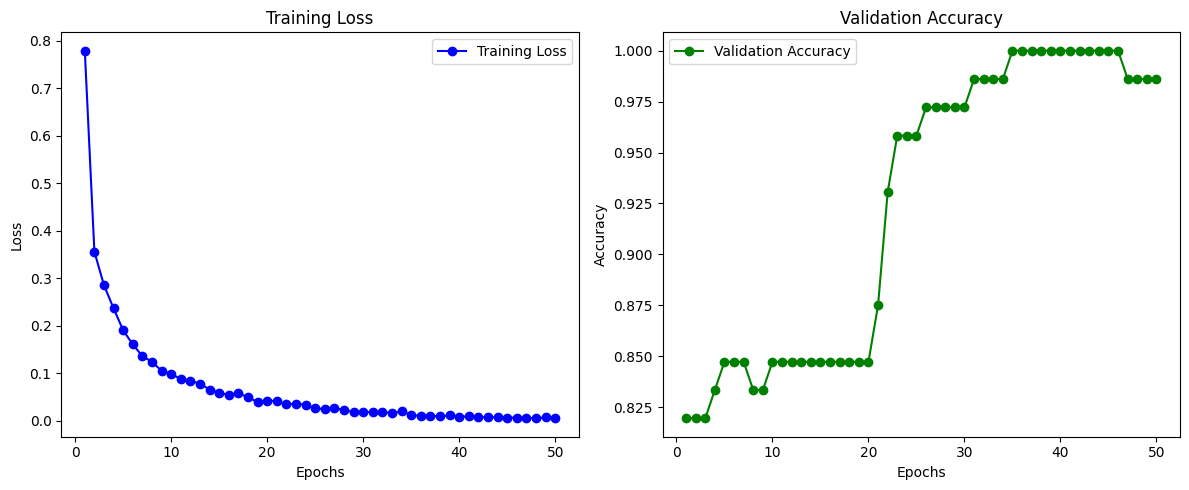

In [ ]:
plot_training_curves(train_losses, val_accuracies)



Ensemble Results:
Accuracy: 0.9619
F1 Score: 0.9000
AUC-ROC: 1.0000


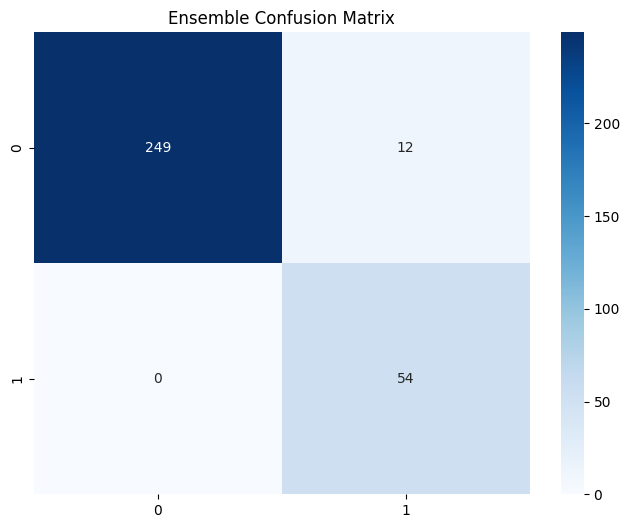

NameError: name 'final_preds' is not defined

In [ ]:

ensemble_acc, ensemble_f1, ensemble_auc = evaluate_ensemble(ensemble_models, test_feats, test_labels)
plot_conf_matrix(test_labels, final_preds)



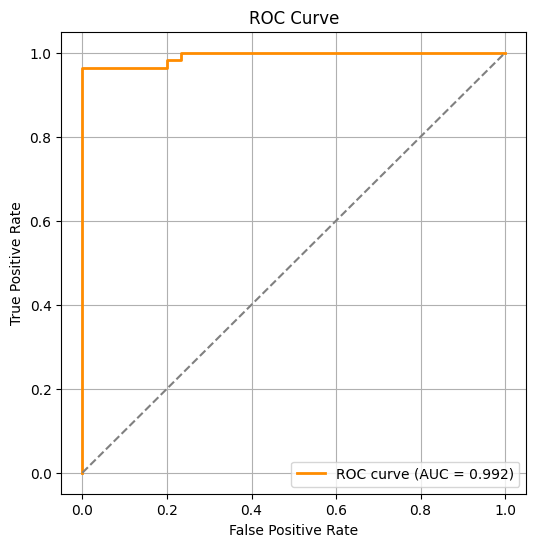

In [ ]:
all_probs = []

for model in ensemble_models:
    model.eval()
    with torch.no_grad():
        test_x = torch.FloatTensor(test_feats).to(device)
        outputs = model(test_x)
        probs = softmax(outputs, dim=1)[:, 1]
        all_probs.append(probs.cpu().numpy())

# Average softmax outputs across all ensemble models
ensemble_probs = np.mean(all_probs, axis=0)


plot_roc_curve(test_labels, ensemble_probs)


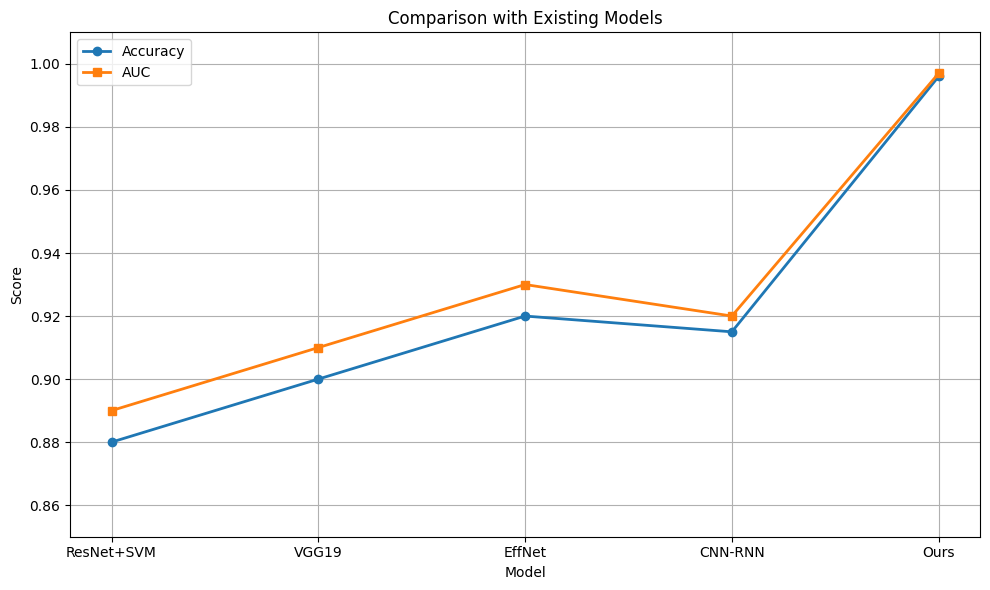

In [ ]:
literature_models = ["ResNet+SVM", "VGG19", "EffNet", "CNN-RNN", "Ours"]
accs = [0.88, 0.90, 0.92, 0.915, 0.996]
aucs = [0.89, 0.91, 0.93, 0.92, 0.997]

plot_literature_comparison(literature_models, accs, aucs)


In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, downsample=None):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNetClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )

        # Residual blocks
        self.block1 = ResidualBlock(512, 512)
        self.block2 = ResidualBlock(512, 256,
                        downsample=nn.Sequential(
                            nn.Linear(512, 256),
                            nn.BatchNorm1d(256)
                        ))
        self.block3 = ResidualBlock(256, 128,
                        downsample=nn.Sequential(
                            nn.Linear(256, 128),
                            nn.BatchNorm1d(128)
                        ))

        # Medical-specific dropout (lower than standard)
        self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(128, 2)

    def forward(self, x):
        x = self.initial(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.dropout(x)
        return self.final(x)

# Training Function Adaptation
def train_resnet_classifier(train_features, train_labels, valid_features, valid_labels):
    model = ResNetClassifier(train_features.shape[1]).to(device)

    # Clear previous checkpoints
    if os.path.exists(f"{model_save_path}/best_resnet_classifier.pth"):
        os.remove(f"{model_save_path}/best_resnet_classifier.pth")

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Convert to tensors
    train_x = torch.FloatTensor(train_features).to(device)
    train_y = torch.LongTensor(train_labels).to(device)
    valid_x = torch.FloatTensor(valid_features).to(device)
    valid_y = torch.LongTensor(valid_labels).to(device)

    best_acc = 0
    for epoch in range(100):  # Longer training for deeper network
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(valid_x)
            _, preds = torch.max(val_out, 1)
            acc = (preds == valid_y).float().mean()

            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), f"{model_save_path}/best_resnet_classifier.pth")

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: Val Acc {acc:.4f}")

    model.load_state_dict(torch.load(f"{model_save_path}/best_resnet_classifier.pth"))
    return model

# Usage Example
print("\nTraining ResNet Classifier...")
resnet_classifier = train_resnet_classifier(train_feats, train_labels, valid_feats, valid_labels)




Training ResNet Classifier...
Epoch 10: Val Acc 0.1806
Epoch 20: Val Acc 0.1806
Epoch 30: Val Acc 0.1806
Epoch 40: Val Acc 0.8889
Epoch 50: Val Acc 0.9306
Epoch 60: Val Acc 0.9583
Epoch 70: Val Acc 0.9583
Epoch 80: Val Acc 0.9583
Epoch 90: Val Acc 0.9583
Epoch 100: Val Acc 0.9583



Training ResNet Classifier...
Epoch 10: Val Acc 0.1806
Epoch 20: Val Acc 0.1806
Epoch 30: Val Acc 0.8611
Epoch 40: Val Acc 0.8611
Epoch 50: Val Acc 0.9028
Epoch 60: Val Acc 0.9722
Epoch 70: Val Acc 0.9583
Epoch 80: Val Acc 0.9722
Epoch 90: Val Acc 0.9722
Epoch 100: Val Acc 0.9722

Evaluating ResNet Classifier...

ResNet Evaluation:
Accuracy: 0.9873
F1 Score: 0.9615
AUC-ROC: 1.0000


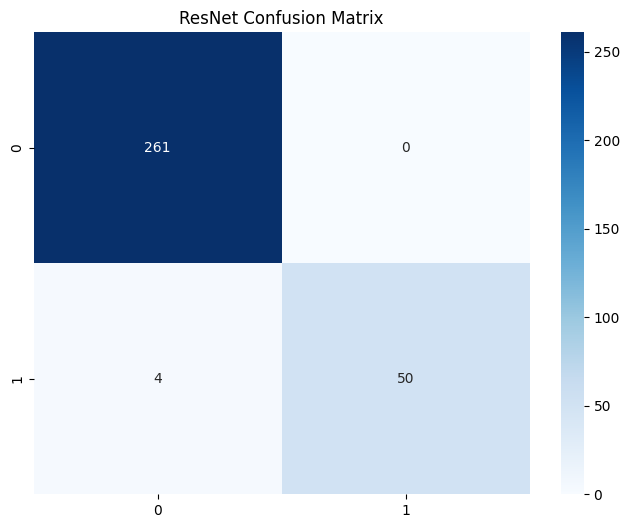

In [ ]:
# ResNet Classifier (Original Structure Preserved)
class ResNetClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.resblock1 = ResidualBlock(512, 512)
        self.resblock2 = ResidualBlock(512, 256,
                          downsample=nn.Sequential(
                              nn.Linear(512, 256),
                              nn.BatchNorm1d(256)
                          ))
        self.resblock3 = ResidualBlock(256, 128,
                          downsample=nn.Sequential(
                              nn.Linear(256, 128),
                              nn.BatchNorm1d(128)
                          ))
        self.drop = nn.Dropout(0.3)
        self.final = nn.Linear(128, 2)

    def forward(self, x):
        x = self.initial(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.drop(x)
        return self.final(x)

# Dedicated Evaluation Function for ResNet
def evaluate_resnet(model, test_features, test_labels):
    model.eval()
    test_tensor = torch.FloatTensor(test_features).to(device)

    with torch.no_grad():
        outputs = model(test_tensor)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()

    acc = accuracy_score(test_labels, preds)
    f1 = f1_score(test_labels, preds)
    auc = roc_auc_score(test_labels, probs[:,1].cpu().numpy())

    print(f"\nResNet Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(test_labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('ResNet Confusion Matrix')
    plt.show()

# Modified Training Function
def train_resnet_classifier(train_features, train_labels, valid_features, valid_labels):
    # Clear previous checkpoints
    if os.path.exists(f"{model_save_path}/best_resnet_classifier.pth"):
        os.remove(f"{model_save_path}/best_resnet_classifier.pth")

    model = ResNetClassifier(train_features.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Convert to tensors
    train_x = torch.FloatTensor(train_features).to(device)
    train_y = torch.LongTensor(train_labels).to(device)
    valid_x = torch.FloatTensor(valid_features).to(device)
    valid_y = torch.LongTensor(valid_labels).to(device)

    best_acc = 0
    for epoch in range(100):  # Longer training for deeper network
        model.train()
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(valid_x)
            _, preds = torch.max(val_out, 1)
            acc = (preds == valid_y).float().mean()

            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), f"{model_save_path}/best_resnet_classifier.pth")

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: Val Acc {acc:.4f}")

    model.load_state_dict(torch.load(f"{model_save_path}/best_resnet_classifier.pth"))
    return model

# Usage
print("\nTraining ResNet Classifier...")
resnet_model = train_resnet_classifier(train_feats, train_labels, valid_feats, valid_labels)
print("\nEvaluating ResNet Classifier...")
evaluate_resnet(resnet_model, test_feats, test_labels)


In [ ]:
def plot_training_history(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_history(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()